# CaMKII system analysis

In [1]:
using ModelingToolkit
using OrdinaryDiffEq
using SteadyStateDiffEq
using DiffEqCallbacks
using Plots
using LsqFit
using CaMKIIModel
using CaMKIIModel: μM, hil, second, Hz
Plots.default(lw=1.5)

## CaMKII sensitivity to calcium
Model CaM/Calcium binding only. No phosphorylation or oxidation.

In [2]:
@parameters Ca = 0μM ROS = 0μM
sys = get_camkii_sys(Ca; ROS, simplify=true)

Model camkii_sys:
Equations (17):
  17 standard: see equations(camkii_sys)
Unknowns (17): see unknowns(camkii_sys)
  Ca2CaM_C(t) [defaults to 0.08433]
  Ca2CaM_N(t) [defaults to 0.008578]
  Ca4CaM(t) [defaults to 2.0e-5]
  CaM0_CaMK(t) [defaults to 1.0]
  ⋮
Parameters (44): see parameters(camkii_sys)
  kCaM0_on [defaults to 3.8e-6]
  kCaM0_off [defaults to 0.0055]
  kCaM4P_on [defaults to 0]
  kCaM2NP_off [defaults to 0.000333333]
  ⋮
Observed (3): see observed(camkii_sys)

In [3]:
prob = SteadyStateProblem(sys, [sys.k_phosCaM => 0])
alg = DynamicSS(Rodas5P())
ca = logrange(0.03μM, 10μM, length=1001)
prob_func = (prob, i, repeat) -> begin
    remake(prob, p=[Ca => ca[i]])
end
trajectories = length(ca)
sol0 = solve(prob, alg; abstol=1e-10, reltol=1e-10) ## warmup
sim = solve(EnsembleProblem(prob; prob_func, safetycopy=false), alg; trajectories, abstol=1e-10, reltol=1e-10)

EnsembleSolution Solution of length 1001 with uType:
SciMLBase.NonlinearSolution{Float64, 1, Vector{Float64}, Vector{Float64}, SciMLBase.SteadyStateProblem{Vector{Float64}, true, ModelingToolkit.MTKParameters{Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, SciMLBase.ODEFunction{true, SciMLBase.AutoSpecialize, ModelingToolkit.var"#f#1023"{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x3c558629, 0x8b8968ce, 0x2f361f91, 0x7d6d2ee5, 0x45852910), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x0dc136ce, 0x6161a537, 0xb84ce11f, 0x11edf59d, 0x5551ee06), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{ModelingToolkit.ODESystem}, Nothing, M

In [4]:
"""Extract values from ensemble simulations by a symbol"""
extract(sim, k) = map(s -> s[k], sim)
"""Calculate Root Mean Square Error (RMSE)"""
rmse(fit) = sqrt(sum(abs2, fit.resid) / length(fit.resid))

Main.var"##230".rmse

Components

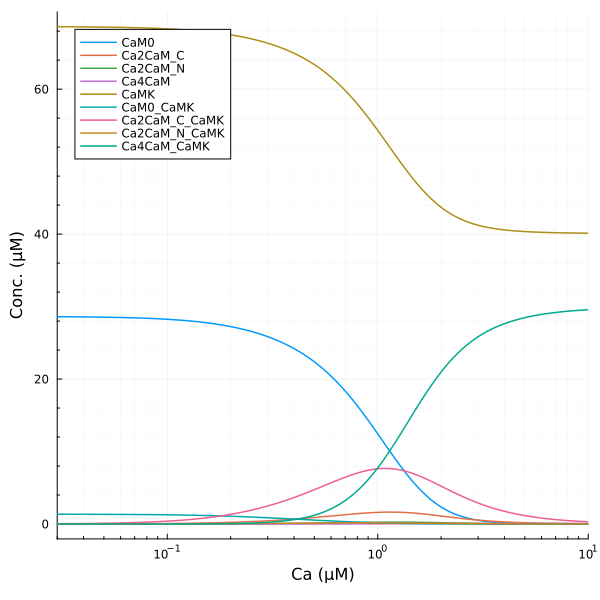

In [5]:
xopts = (xlabel="Ca (μM)", xscale=:log10, minorgrid=true, xlims=(ca[1], ca[end]))
plot(ca, extract(sim, sys.CaM0), lab="CaM0", ylabel="Conc. (μM)"; xopts...)
plot!(ca, extract(sim, sys.Ca2CaM_C), lab="Ca2CaM_C")
plot!(ca, extract(sim, sys.Ca2CaM_N), lab="Ca2CaM_N")
plot!(ca, extract(sim, sys.Ca4CaM), lab="Ca4CaM")
plot!(ca, extract(sim, sys.CaMK), lab="CaMK")
plot!(ca, extract(sim, sys.CaM0_CaMK), lab="CaM0_CaMK")
plot!(ca, extract(sim, sys.Ca2CaM_C_CaMK), lab="Ca2CaM_C_CaMK")
plot!(ca, extract(sim, sys.Ca2CaM_N_CaMK), lab="Ca2CaM_N_CaMK")
plot!(ca, extract(sim, sys.Ca4CaM_CaMK), lab="Ca4CaM_CaMK", legend=:topleft, size=(600, 600))

We excluded CaM0_CaMK (bound but lost all calcium) from the active CaMKII fraction

Basal activity without ca is 4.7190264362839685e-8


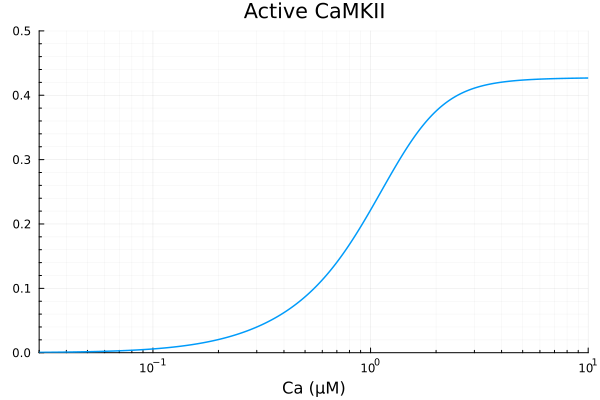

In [6]:
CaMKAct = 1 - (sys.CaMK + sys.CaM0_CaMK) / sys.CAMKII_T
println("Basal activity without ca is ", sol0[CaMKAct][end])
xdata = ca
ydata = extract(sim, CaMKAct)
plot(xdata, ydata, label=false, title="Active CaMKII", ylims=(0, 0.5); xopts...)

## Least-square fitting of steady state CaMKII activity

In [7]:
@. model_camk(x, p) = p[1] * hil(x, p[2], p[4]) + p[3]
p0 = [0.4, 1μM, 0.0, 2.0]
lb = [0.0, 0.001μM, 0.0, 1.0]
fit = curve_fit(model_camk, xdata, ydata, p0; lower=lb, autodiff=:forwarddiff)

LsqFit.LsqFitResult{Vector{Float64}, Vector{Float64}, Matrix{Float64}, Vector{Float64}, Vector{LsqFit.LMState{LsqFit.LevenbergMarquardt}}}([0.42985864578066807, 0.962948175716529, 0.005187220988015051, 2.2985815732376373], [0.004766880298358606, 0.004762306110170087, 0.004757683534689944, 0.004753011863478671, 0.004748290836277292, 0.004743519793931492, 0.00473869819245602, 0.004733825687175531, 0.00472890171727138, 0.004723925639757031  …  0.0061555861352246555, 0.006174154405299281, 0.006192218504692759, 0.006210314714702347, 0.006228215844057972, 0.006245510256971842, 0.006262960333958512, 0.006280198571436246, 0.006297175009291944, 0.006313692872837395], [0.0003444129030642761 -0.0003532746569387042 1.0 -0.0005133753534451857; 0.0003490410009471264 -0.00035802017838184935 1.0 -0.0005194002101594269; … ; 0.9953494639187168 -0.004749646385869066 1.0 0.004645195904527165; 0.9954108657166175 -0.0046872251491184205 1.0 0.004595554371576107], true, Iter     Function value   Gradient norm

Parameters

In [8]:
pestim = coef(fit)

4-element Vector{Float64}:
 0.42985864578066807
 0.962948175716529
 0.005187220988015051
 2.2985815732376373

In [9]:
println("Basal activity: ", pestim[3])
println("Maximal activated activity: ", pestim[1])
println("Half-saturation Ca concentration: ", pestim[2], " μM")
println("Hill coefficient: ", pestim[4])
println("RMSE: ", rmse(fit))

Basal activity: 0.005187220988015051
Maximal activated activity: 0.42985864578066807
Half-saturation Ca concentration: 0.962948175716529 μM
Hill coefficient: 2.2985815732376373
RMSE: 0.004825705522024998


Fit result and the original model

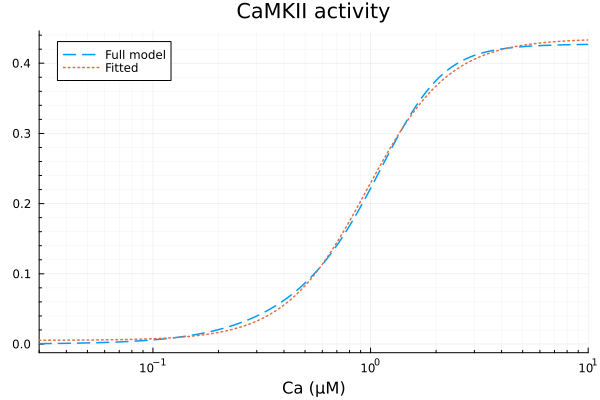

In [10]:
yestim = model_camk.(xdata, Ref(pestim))

p1 = plot(xdata, [ydata yestim], lab=["Full model" "Fitted"], line=[:dash :dot], title="CaMKII activity", legend=:topleft; xopts...)

## The simplified CaMKII system

In [11]:
simpsys = CaMKIIModel.get_camkii_simp_sys(Ca; ROS, simplify=true)

Model camkii_sys:
Equations (8):
  8 standard: see equations(camkii_sys)
Unknowns (8): see unknowns(camkii_sys)
  CaMKB(t) [defaults to 0.008728]
  CaMKBOX(t) [defaults to 0]
  CaMKP(t) [defaults to 0.003916]
  CaMKPOX(t) [defaults to 0.0]
  ⋮
Parameters (14): see parameters(camkii_sys)
  nCa_CaMK [defaults to 2.293]
  k_P2_P1 [defaults to 6.66667e-5]
  krd_CaMK [defaults to 2.22222e-5]
  kox_CaMK [defaults to 0.000291]
  ⋮
Observed (2): see observed(camkii_sys)

## Comparing original and simplified model

In [12]:
sys = build_neonatal_ecc_sys(simplify=true, reduce_iso=true)
sys_simp = build_neonatal_ecc_sys(simplify=true, reduce_iso=true, reduce_camk=true)

println("# of state variable in the original model: ", length(unknowns(sys)))
println("# of state variable in the simplified model: ", length(unknowns(sys_simp)))

# of state variable in the original model: 84
# of state variable in the simplified model: 75


In [13]:
tend = 500.0second
stimstart = 100.0second
stimend = 300.0second
alg = FBDF()
@unpack Istim = sys
callback = build_stim_callbacks(Istim, stimend; period=1second, starttime=stimstart)
prob = ODEProblem(sys, [], tend)
prob_simp = ODEProblem(sys_simp, [sys_simp.kphos_CaMK => 5Hz], tend)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 500000.0)
u0: 75-element Vector{Float64}:
      0.0026
    830.0
    830.0
      0.00702
      0.966
      0.22156
      0.09243
      0.00188
      0.00977
      0.26081
      ⋮
      0.12113
      0.12113
      0.12113
      0.12113
      0.12113
      0.12113
    -68.79268
  13838.37602
 150952.75035000002

In [14]:
@time sol = solve(prob, alg; callback)
@time sol_simp = solve(prob_simp, alg; callback)

  9.200504 seconds (22.49 M allocations: 1.100 GiB, 4.34% gc time, 79.06% compilation time)
  5.378168 seconds (12.31 M allocations: 601.277 MiB, 4.29% gc time, 65.35% compilation time)


retcode: Success
Interpolation: 3rd order Hermite
t: 42230-element Vector{Float64}:
      0.0
      1.397037556582821e-7
      9.238890872600831e-6
      8.268743701533588e-5
      0.0002916748356969014
      0.0017327691557383657
      0.0051472024471516595
      0.009381914366487651
      0.01412353770711788
      0.02222607464446686
      ⋮
 397723.82057004934
 406750.01662236196
 417776.8861123902
 430066.5613446226
 442356.23657685495
 454645.9118090873
 466935.5870413197
 481624.081564708
 500000.0
u: 42230-element Vector{Vector{Float64}}:
 [0.0026, 830.0, 830.0, 0.00702, 0.966, 0.22156, 0.09243, 0.00188, 0.00977, 0.26081  …  0.12113, 0.12113, 0.12113, 0.12113, 0.12113, 0.12113, 0.12113, -68.79268, 13838.37602, 150952.75035000002]
 [0.002599999989610171, 829.9999999963668, 829.9999999997507, 0.00702000000187161, 0.9660000000132074, 0.2215600000288606, 0.09242999998313912, 0.0018799999988577344, 0.009769999999149391, 0.2608099999679793  …  0.12113, 0.12113, 0.12113, 0.12113, 0.121

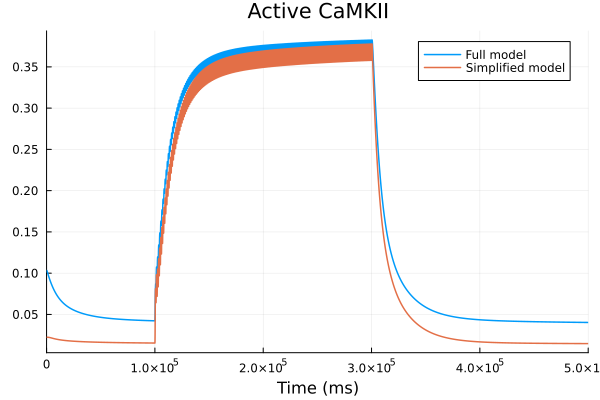

In [15]:
plot(sol, idxs=sys.CaMKAct, label= "Full model", title="Active CaMKII")
plot!(sol_simp, idxs=sys_simp.CaMKAct, label= "Simplified model", xlabel="Time (ms)")

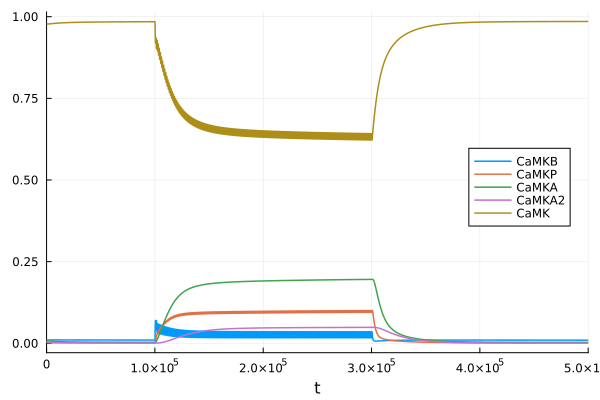

In [16]:
@unpack CaMKB, CaMKP, CaMKA, CaMKA2, CaMK = sys_simp
plot(sol_simp, idxs=[CaMKB, CaMKP, CaMKA, CaMKA2, CaMK], legend=:right)

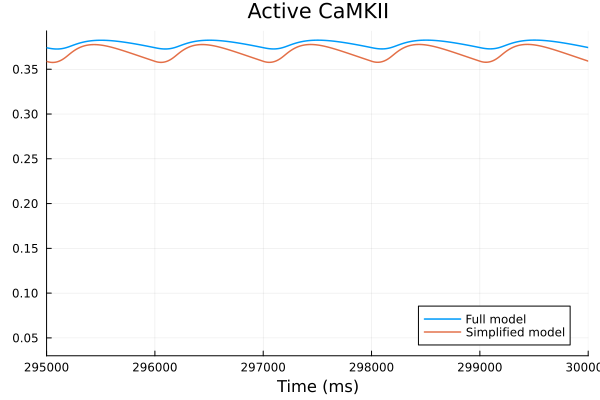

In [17]:
plot(sol, idxs=sys.CaMKAct, label= "Full model", title="Active CaMKII")
plot!(sol_simp, idxs=sys_simp.CaMKAct, label= "Simplified model", xlabel="Time (ms)", tspan=(295second,300.0second))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*